# Evaluate the Performance and Accuracy as a Function of Runtime
Longer MD simulations are good because they produce more accurate estimates of stability and are less affected by the inefficiencies of task startup.
However, they take longer.
We explore the tradeoff between these effects in this notebook.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

Configuration

In [2]:
target_system = 'polaris'

## Load Runtime Results
We saved the results of tests with different MOFs and different system configurations in `runtime.json`

In [3]:
runtimes = pd.read_json('runtimes.json', lines=True)
print(f'Loaded {len(runtimes)} experiments')

Loaded 996 experiments


Get a short name for the LAMMPS executable

In [4]:
runtimes['build'] = runtimes.lammps_cmd.apply(lambda x: x[0]).apply(lambda x: Path(x).parent.name[6:])

Get only the target system and LAMMPS executable

In [5]:
runtimes = runtimes[runtimes.host.str.startswith(target_system)]
runtimes = runtimes[runtimes.build.str.len() > 0]
print(f'Downselected to {len(runtimes)} experiments')

Downselected to 633 experiments


In [6]:
runtimes['rate'] = runtimes['timesteps'] / runtimes['runtime']

## Plot Strain Over Timesteps
See how much the measurements of strain change over time. Get the relative difference between the strain and that computed with the maximum timestep count for each MOF

In [7]:
def error_from_best_estimate(group):
    best_est = group[group.timesteps == group['timesteps'].max()]['strain'].mean()
    return (1 - group['strain'] / best_est) * 100

In [8]:
runtimes['error'] = runtimes.groupby('mof', group_keys=False).apply(error_from_best_estimate)

In [9]:
avg_by_length = runtimes.groupby('timesteps')[['error']].agg(['mean', 'std'])

Text(0, 0.5, 'Error, Relative (%)')

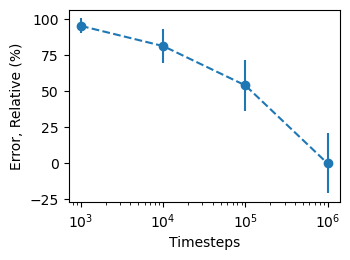

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.errorbar(avg_by_length.index, avg_by_length['error']['mean'], fmt='--o', yerr=avg_by_length['error']['std'])
ax.set_xscale('log')


ax.set_xlabel('Timesteps')
ax.set_ylabel('Error, Relative (%)')

## Compare Builds
Compare builds with a runtime of 1e6 timesteps

In [11]:
subset = runtimes.query('timesteps == 1000000')

In [12]:
summary = subset.groupby('build')['rate'].agg(['mean', 'std'])
summary

,mean,std
build,,
gpu-nompi-mixed,2791.492783,272.368439
kokkos-nompi,712.631700,36.568745


Text(0, 0.5, 'Rate (steps/s)')

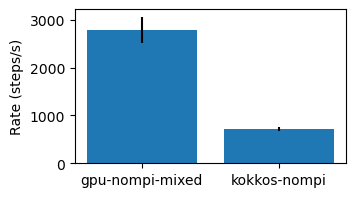

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.bar(summary.index, summary['mean'], yerr=summary['std'])

ax.set_ylabel('Rate (steps/s)')

In [14]:
best_build = summary['mean'].idxmax()
runtimes.query(f'build=="{best_build}"', inplace=True)
print(f'Filtered to only {best_build}')

Filtered to only gpu-nompi-mixed


## Plot Timestep Rate vs Timestep Count
We should see faster simulations at larger timesteps

In [15]:
avg_by_length = runtimes.groupby('timesteps')[['runtime', 'rate']].mean()

Text(0, 0.5, 'Rate (steps/s)')

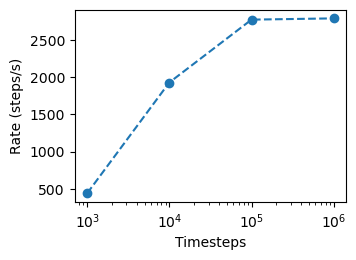

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogx(avg_by_length.index, avg_by_length['rate'], '--o')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Rate (steps/s)')

We need $10^5$ steps on Polaris to get full performance on a GPU